# Random Forest House Data Interpretation
 

## Interpretaton

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
import shap
import lime
import lime.lime_tabular as lt
from data_import import load_boston

In [2]:
#Read in the data as pandas dataframe
X, y = load_boston()

#quick look to see above worked. 
X.head()



CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

In [3]:
#load in saved random forest regressor model 
from sklearn.externals import joblib
regressor = joblib.load('../Models/Basic_random_forest.sav')


/home/jupyter-khickey550/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Now, we need to establish an 'explainer' object that will eventually explain some of our model's predictions. 

In [10]:
#also build a predict_proba

explainer = lt.LimeTabularExplainer(X.values, 
                                    mode = 'regression', 
                                    feature_names=list(X.columns), 
                                    class_names = ['MEDV'],)


In [12]:
#define a 

#show 3 seperate examples, 
for i in [1,200,10]:
    print(f"Actual Value: {y.values[i]}")
    exp = explainer.explain_instance(X.values[i], predict_fn=regressor.predict, num_features=7)
    exp.show_in_notebook(show_predicted_value=True, predict_proba=False, )
    

Actual Value: 21.6


Actual Value: 32.9


Actual Value: 15.0


Analysis: We have the predicted value for an example, the actual feature values for that particular example, and the feature-value pair that mimics contribution to prediction. On the last instance, since LSTAT is >= 16.96, this particular home is "7.03 less expensive", on average. In another way, if this house did not have LSTAT <= 7.17, this house would be on average "7.46 more expensive". This house is also associated with a low predicted and actual price, whereas the second house is a somewhat more expensive house because its _LSTAT_ value is below 6.95 and the average number of rooms per dwelling is above 6.62. We can see how house prices are associated with values of such features, and we can see here what specific values seem to be key values that influence the predicted house price. 


Now let's turn to SHAP and examine its capabilities. 

First, need to initialize Javascript plotting in the notebook. Then, build an explainer and calculate all shap values on a particular dataset we pass it. 

In [15]:
shap.initjs()

explainer_shap = shap.TreeExplainer(regressor)
shap_values = explainer_shap.shap_values(X)

Build a force plot which can show, for an individual example, how feature-value combinations affect model output. Below, the model's predicton is 28.43, and the average prediction on the dataset the model was trained on is the 'base vale', of 22.25.  The features-values in red are contributing to the model prediction higher than the base value, and the feature-values in blue are contributing to the model predicting lower than the base value. 

In [17]:
i = 10
shap.force_plot(explainer_shap.expected_value, shap_values[i,:], X.iloc[i,:])


In [20]:
i = 200
shap.force_plot(explainer_shap.expected_value, shap_values[i,:], X.iloc[i,:])

If we combine all such force plots for all instances, we can build a wholistic force plot for the entire dataset. Below, we can look at how the values of _RM_ and _LSTAT_ together and see that high values of _RM_ and low value of _LSTAT_ together are associated with the highest values of prediction (output value).  

In [18]:
shap.force_plot(explainer_shap.expected_value, shap_values, X)

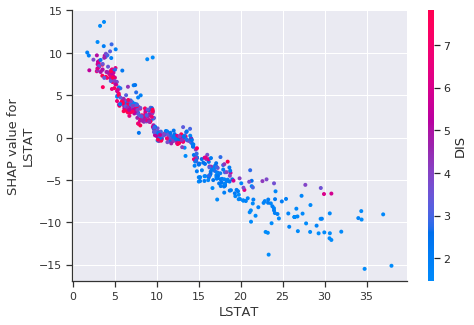

In [32]:
shap.dependence_plot('LSTAT', shap_values, X)

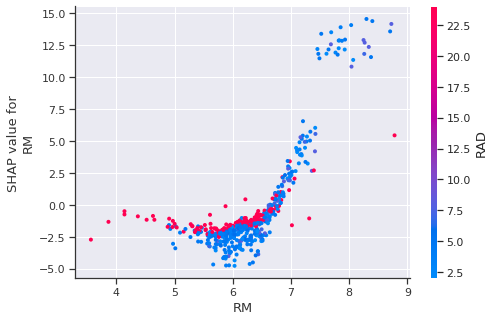

In [35]:
shap.dependence_plot('RM', shap_values, X)

SHAP can also score feature importances for the entire dataset. 

In the chart below, there are two main elements: first is the ordering of the featues on the left y-axis. This ordering indicates the ranking of important features; LSTAT is scored as the most important feature. The second element is the color and horizontal placement on the grid. For an individual feature, a single dot represents a single instance in the dataset. The color indicates the feature value; closer to red is a higher value, and a color closer to blue is a lower value. Where it is placed shows the SHAP value of that particular example's feature value; those examples below 0 have a negative SHAP value, so they contribute to the model predicting lower than the base value, and vice-versa.

For instance, the chart shows that a higher value for RM contributes to higher predicted home prices.  

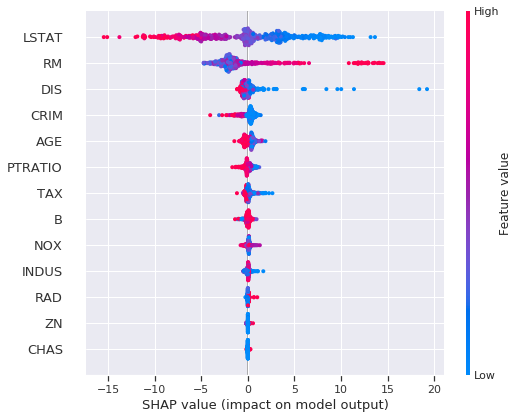

In [19]:
shap.summary_plot(shap_values, X)

In [21]:
shap_interaction_values = explainer_shap.shap_interaction_values(X)

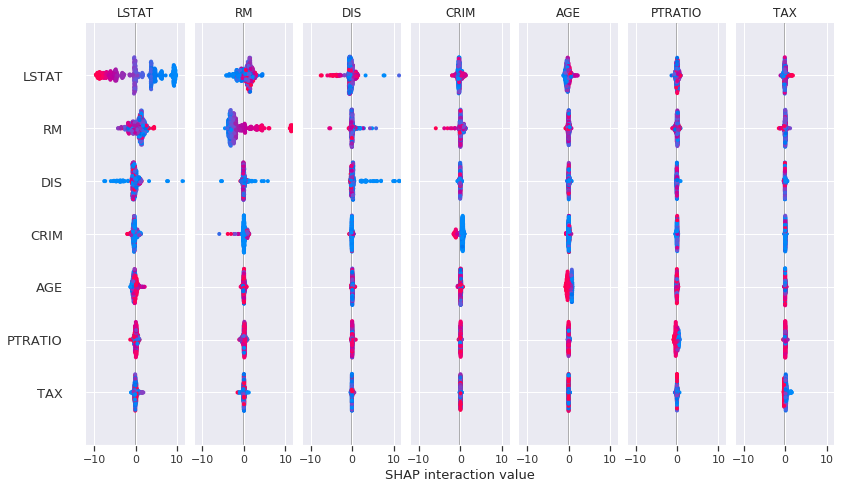

In [22]:
shap.summary_plot(shap_interaction_values, X)


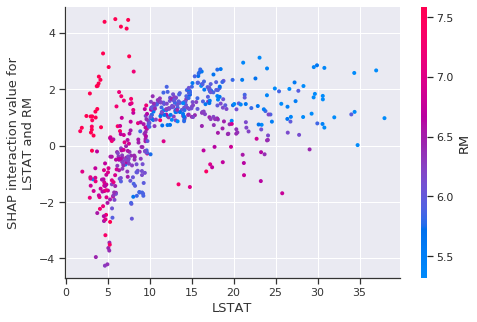

In [31]:
shap.dependence_plot( ('LSTAT', 'RM'), shap_interaction_values, X)

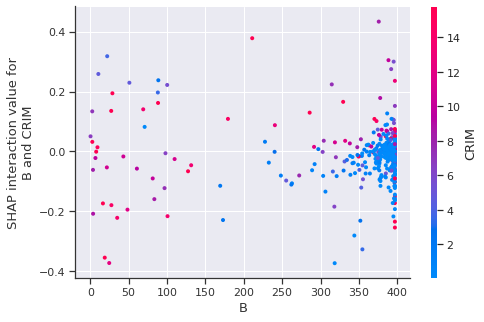

In [47]:
shap.dependence_plot( ('B', 'CRIM'), shap_interaction_values, X)